### 拡散モデルの理論

拡散モデルは、最初は雑音除去拡散確率モデル(DDPM)として導入されましたが、これは離散時間的なモデルでした。これを連続時間的なモデルにするさいに、ある確率微分方程式の時間を逆向きにした過程を用いて定式化をおこった研究がありました。今回はこれに注目します。

拡散モデルの目標は、分布 $p_0$ に従う確率変数 $X_0$ を生成することです。確率変数に注目するので確率過程がでてきます。$p_0$は例えば自然な画像とかそういういい感じの分布のことです。

#### 順過程(OU過程)の実装


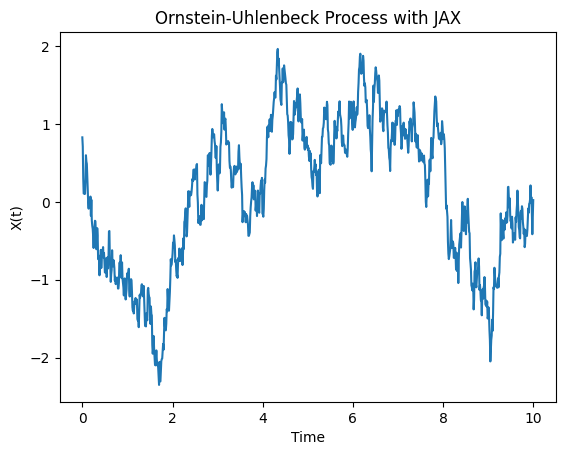

In [12]:
import jax
import jax.numpy as jnp
from jax import random
import matplotlib.pyplot as plt

# パラメータの設定
theta = 1.0  # ドリフト係数
mu = 0.0     # 平均
sigma = jnp.sqrt(2)  # ボラティリティ
X0 = 1.0     # 初期値
T = 10.0     # シミュレーションの終了時間
N = 1000     # 時間ステップ数
dt = T / N   # 時間ステップ幅

# JAX乱数
key = random.PRNGKey(0)

# 時間グリッド
t = jnp.linspace(0, T, N)

# OU過程のシミュレーション関数
def simulate_ou_process(key, X0, theta, mu, sigma, dt, N):
    def step(X, key):
        dB = random.normal(key) * jnp.sqrt(dt)  # ブラウン運動の増分
        X = X + theta * (mu - X) * dt + sigma * dB
        return X, X
    
    keys = random.split(key, N)
    _, X_path = jax.lax.scan(step, X0, keys)
    return X_path

# シミュレーションの実行
X_path = simulate_ou_process(key, X0, theta, mu, sigma, dt, N)

# シミュレーションのプロット
plt.plot(t, X_path)
plt.xlabel('Time')
plt.ylabel('X(t)')
plt.title('Ornstein-Uhlenbeck Process')
plt.show()


#### OU過程に従う確率変数が標準正規分布に収束することを確認

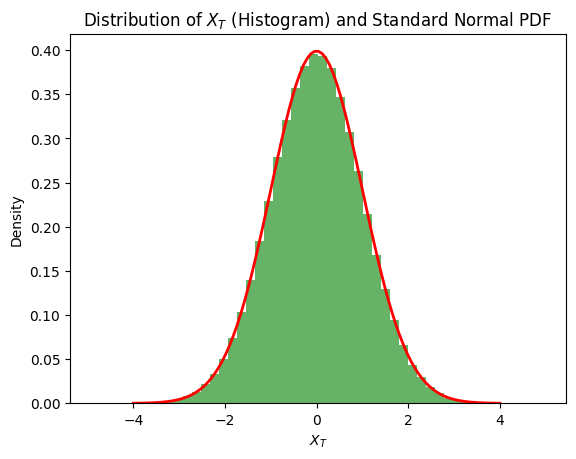

In [13]:
# シミュレーションの繰り返し回数
num_simulations = 1000000

def simulate_multiple_ou_processes(key, X0, theta, mu, sigma, dt, N, num_simulations):
    keys = random.split(key, num_simulations)
    X_T = jax.vmap(lambda k: simulate_ou_process(k, X0, theta, mu, sigma, dt, N)[-1])(keys)
    return X_T

# シミュレーションの実行
X_T = simulate_multiple_ou_processes(key, X0, theta, mu, sigma, dt, N, num_simulations)

# ヒストグラムのプロット
plt.hist(X_T, bins=50, density=True, alpha=0.6, color='g')

# 標準正規分布をプロット
x = jnp.linspace(-4, 4, 100)
pdf = (1/jnp.sqrt(2*jnp.pi)) * jnp.exp(-x**2 / 2)
plt.plot(x, pdf, 'r', linewidth=2)
plt.title('Distribution of $X_T$ (Histogram) and Standard Normal PDF')
plt.xlabel('$X_T$')
plt.ylabel('Density')
plt.show()


#### 逆過程をつかって標準正規分布をガウス分布に遷移させよう